In [6]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

torch_device = "cuda" if torch.cuda.is_available() else "cpu"

model_checkpoint = "meta-llama/Llama-3.2-3B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForCausalLM.from_pretrained(model_checkpoint, pad_token_id=tokenizer.eos_token_id)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

1. Greedy Search
: 타임스텝 t에서 가장 높은 확률을 가지는 토큰을 다음 토큰으로 선택하는 전략

In [8]:
# encode context the generation is conditioned on
model_inputs = tokenizer('I enjoy walking with my cute dog', return_tensors='pt')

# generate 40 new tokens
greedy_output = model.generate(**model_inputs, max_new_tokens=40)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(greedy_output[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute doggy in the park. We have a nice time together, and I feel very happy.
I like to take my dog to the park to play fetch and go for walks. It's a great way


2. Beam Search
: 각 타임스텝에서 가장 가능성 있는 num_beams개의 시퀀스를 유지하고, 최종적으로 가장 확률이 높은 가설을 선택하는 방법

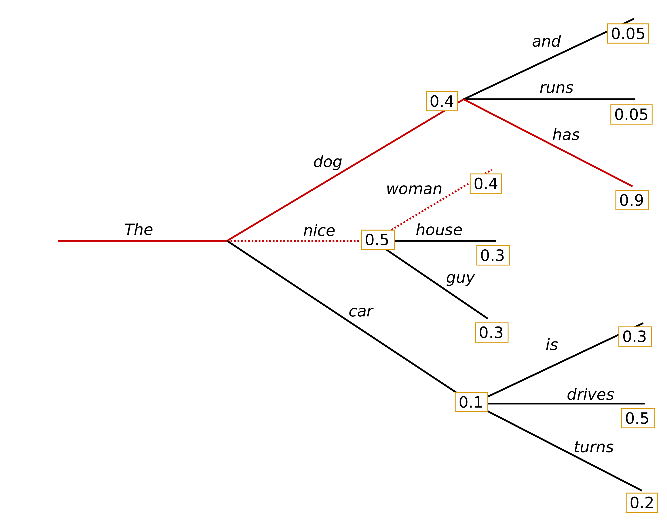

위의 그림은 num_beams=2로 디코딩할 때의 예시를 보여준다. 첫 번째 타임 스텝에서는 가장 높은 확률을 가지는 [The, nice (p=0.5)]와 [The, dog (p=0.4)] 두 개의 시퀀스를 유지한다. 두 번째 타임 스텝에서는 [The, nice, woman(p=0.20)]과 [The, dog, has(p=0.36)] 두 개의 시퀀스가 선택되고, greedy decoding과는 달리 더 확률이 높은 (The, dog, has)의 시퀀스를 선택하게 된다.

In [3]:
beam_output = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, #1보다 큰 값을 지정
    early_stopping=True #EOS토큰이 나오면 생성을 중단
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, Luna. She loves going on adventures with me, and I love watching her explore the world around her. One day, while we were out on a walk, we stumbled upon a hidden path that we had


2-1) n-gram 패널티 주기

- 동어 반복을 피하고 좀더 자연스러운 문장을 생성하기 위해 n-grams 페널티 전략을 적용할 수 있다.

- n-gram 단위의 어구가 두 번 등장할 일이 없도록, 이러한 일이 발생할 확률을 0으로 만드는 전략이다.

- 코드상에서는 아래와 같이 no_repeat_ngram_size 옵션을 설정함으로써 구현할 수 있다.

In [4]:
beam_output = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    no_repeat_ngram_size=2, # 2-gram의 어구가 반복되지 않도록 설정함
    early_stopping=True
)

print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, Luna. She loves going on adventures with me, and I love watching her explore the world around her. One day, while we were out on a walk, we stumbled upon a hidden path that we had
